In [ ]:
# Simple Moirai Inference and Visualization
# Load model, run inference, and visualize results

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download
import warnings
warnings.filterwarnings('ignore')

from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

# Configuration
MODEL = "moirai"  # or "moirai-moe"
SIZE = "large"    # small, base, large
CTX = 256          # Context length
PDT = 16           # Prediction length
BSZ = 32          # Batch size
GPU = 0           # GPU device
PSZ = 1#"auto"
compression_ratio = 0.5

# Data configuration
CSV_PATH = "/home/sa53869/time-series/moirai/time-moe-eval/synthetic_sinusoidal.csv"
COLUMN = 1        # Column to analyze (0-indexed)
TEST_LENGTH = 200 # Test set length

# Set GPU
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)

print(f"Configuration:")
print(f"  Model: {MODEL}-{SIZE}")
print(f"  Context Length: {CTX}")
print(f"  Prediction Length: {PDT}")
print(f"  Test Length: {TEST_LENGTH}")
print(f"  Using GPU: {GPU}")

# Load and prepare data
print("Loading data...")
df = pd.read_csv(CSV_PATH, index_col=0, parse_dates=True)
dataset_name = os.path.splitext(os.path.basename(CSV_PATH))[0]

# Select column
available_columns = df.columns.tolist()
selected_column = available_columns[COLUMN]
df_selected = df[[selected_column]].copy()

print(f"Dataset: {dataset_name}")
print(f"Selected column: {selected_column}")
print(f"Data shape: {df_selected.shape}")
print(f"Data preview:")
print(df_selected.head())

# Create results directory
results_dir = f"results_inf/{dataset_name}/{MODEL}-{SIZE}"
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

# Create GluonTS dataset
ds = PandasDataset(dict(df_selected))
train, test_template = split(ds, offset=-TEST_LENGTH)

# Generate test instances
test_data = test_template.generate_instances(
    prediction_length=PDT,
    windows=TEST_LENGTH // PDT,
    distance=PDT,
)

print(f"Number of test windows: {TEST_LENGTH // PDT}")

# Load Moirai model
print("Loading Moirai model...")
base_module = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}")

# Create model with specific configuration
model = MoiraiForecast(
    module=base_module,
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,  # Number of samples for probabilistic forecasting
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

# Create model with reduced context length
reduced_ctx = int(compression_ratio * CTX)
model_reduced = MoiraiForecast(
    module=base_module,
    prediction_length=PDT,
    context_length=reduced_ctx,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

# Create predictor
predictor = model.create_predictor(batch_size=BSZ)
# Create predictor with reduced context length
predictor_reduced = model_reduced.create_predictor(batch_size=BSZ)
print("Model loaded successfully!")

# Run inference on test data
print("Running inference...")
input_data = list(test_data.input)
label_data = list(test_data.label)

# create a new input data with every second value for reduced context; start by duplicating the input data and replacing the 'target' in each item
input_data_reduced = []
for item in input_data:
    # Create a deep copy of the item to avoid modifying original
    reduced_item = item.copy()
    
    # Replace target with every second value (50% reduction)
    original_target = item['target']
    reduced_target = original_target[::2]  # Take every 2nd sample
    reduced_item['target'] = reduced_target
    
    # Update other time-related fields if they exist
    # Note: start time usually stays the same, but we might need to adjust other fields
    
    input_data_reduced.append(reduced_item)

# Run predictions
forecasts = list(predictor.predict(input_data))
forecasts_reduced = list(predictor_reduced.predict(input_data_reduced))

print(f"Generated {len(forecasts)} forecasts")

# Prepare data for visualization
sample_results = []
full_data_values = df_selected[selected_column].values

for i, (input_item, label_item, forecast) in enumerate(zip(input_data, label_data, forecasts)):
    # Get context data
    context = input_item['target']
    
    # keep the last `CTX` values for context
    if len(context) > CTX:
        context = context[-CTX:]

    # Get ground truth
    ground_truth = label_item['target'][:PDT]
    
    # Get prediction (mean of samples)
    prediction = np.mean(forecast.samples, axis=0)
    
    # Store results
    sample_results.append({
        'window_id': i,
        'context': context,
        'ground_truth': ground_truth,
        'prediction': prediction,
        'mae': np.mean(np.abs(prediction - ground_truth))
    })

print(f"Processed {len(sample_results)} samples")


# repreat for reduced context length
sample_results_reduced = []
for i, (input_item, label_item, forecast) in enumerate(zip(input_data_reduced, label_data, forecasts_reduced)):
    # Get context data
    context = input_item['target']
    
    # keep the last `reduced_ctx` values for context
    if len(context) > reduced_ctx:
        context = context[-reduced_ctx:]

    # Get ground truth
    ground_truth = label_item['target'][:PDT]
    
    # Get prediction (mean of samples)
    prediction = np.mean(forecast.samples, axis=0)
    
    # Store results
    sample_results_reduced.append({
        'window_id': i,
        'context': context,
        'ground_truth': ground_truth,
        'prediction': prediction,
        'mae': np.mean(np.abs(prediction - ground_truth))
    })

# create a new input data with every second value replaced by 0 and then refilled using interpolation
# This maintains the original context length but tests robustness to missing data
input_data_reduced_interpolated = []
for item in input_data:
    # Create a deep copy of the item to avoid modifying original
    reduced_item = item.copy()
    
    # Start with original target
    original_target = item['target']
    target_with_zeros = original_target.copy()
    
    # Replace every second value with 0 (creating missing values)
    target_with_zeros[1::2] = 0  # Set every second value to 0
    
    # Create mask for non-zero values (valid data points)
    valid_mask = target_with_zeros != 0
    valid_indices = np.where(valid_mask)[0]
    valid_values = target_with_zeros[valid_mask]
    
    # Interpolate to fill the zero positions
    all_indices = np.arange(len(target_with_zeros))
    interpolated_target = np.interp(all_indices, valid_indices, valid_values)
    
    # Keep the same context length as original
    if len(interpolated_target) > CTX:
        interpolated_target = interpolated_target[-CTX:]
    
    reduced_item['target'] = interpolated_target
    input_data_reduced_interpolated.append(reduced_item)

# Run predictions with interpolated reduced context
forecasts_reduced_interpolated = list(predictor.predict(input_data_reduced_interpolated))

# Prepare data for visualization with interpolated reduced context
sample_results_reduced_interpolated = []
for i, (input_item, label_item, forecast) in enumerate(zip(input_data_reduced_interpolated, label_data, forecasts_reduced_interpolated)):
    # Get context data
    context = input_item['target']
    
    # Get ground truth
    ground_truth = label_item['target'][:PDT]
    
    # Get prediction (mean of samples)
    prediction = np.mean(forecast.samples, axis=0)
    
    # Store results
    sample_results_reduced_interpolated.append({
        'window_id': i,
        'context': context,
        'ground_truth': ground_truth,
        'prediction': prediction,
        'mae': np.mean(np.abs(prediction - ground_truth))
    })

# create a new input data with only the most recent values (truncated context)
# This maintains the reduced context length but uses only the most recent data
input_data_truncated = []
for item in input_data:
    # Create a deep copy of the item to avoid modifying original
    truncated_item = item.copy()
    
    # Take only the most recent values to match reduced context length
    original_target = item['target']
    
    # Take the last reduced_ctx values (most recent)
    if len(original_target) > reduced_ctx:
        truncated_target = original_target[-reduced_ctx:]
    else:
        truncated_target = original_target
    
    truncated_item['target'] = truncated_target
    input_data_truncated.append(truncated_item)

# Run predictions with truncated context
forecasts_truncated = list(predictor_reduced.predict(input_data_truncated))

# Prepare data for visualization with truncated context
sample_results_truncated = []
for i, (input_item, label_item, forecast) in enumerate(zip(input_data_truncated, label_data, forecasts_truncated)):
    # Get context data
    context = input_item['target']
    
    # Get ground truth
    ground_truth = label_item['target'][:PDT]
    
    # Get prediction (mean of samples)
    prediction = np.mean(forecast.samples, axis=0)
    
    # Store results
    sample_results_truncated.append({
        'window_id': i,
        'context': context,
        'ground_truth': ground_truth,
        'prediction': prediction,
        'mae': np.mean(np.abs(prediction - ground_truth))
    })

Configuration:
  Model: moirai-large
  Context Length: 256
  Prediction Length: 16
  Test Length: 200
  Using GPU: 0
Loading data...
Dataset: synthetic_sinusoidal
Selected column: COS_WAVE
Data shape: (200000, 1)
Data preview:
                     COS_WAVE
date                         
2024-01-01 00:00:00  4.500000
2024-01-01 01:00:00  4.370820
2024-01-01 02:00:00  3.994404
2024-01-01 03:00:00  3.403170
2024-01-01 04:00:00  2.648034
Results will be saved to: results_inf/synthetic_sinusoidal_moirai-large
Number of test windows: 12
Loading Moirai model...
Dataset: synthetic_sinusoidal
Selected column: COS_WAVE
Data shape: (200000, 1)
Data preview:
                     COS_WAVE
date                         
2024-01-01 00:00:00  4.500000
2024-01-01 01:00:00  4.370820
2024-01-01 02:00:00  3.994404
2024-01-01 03:00:00  3.403170
2024-01-01 04:00:00  2.648034
Results will be saved to: results_inf/synthetic_sinusoidal_moirai-large
Number of test windows: 12
Loading Moirai model...
Model loaded 

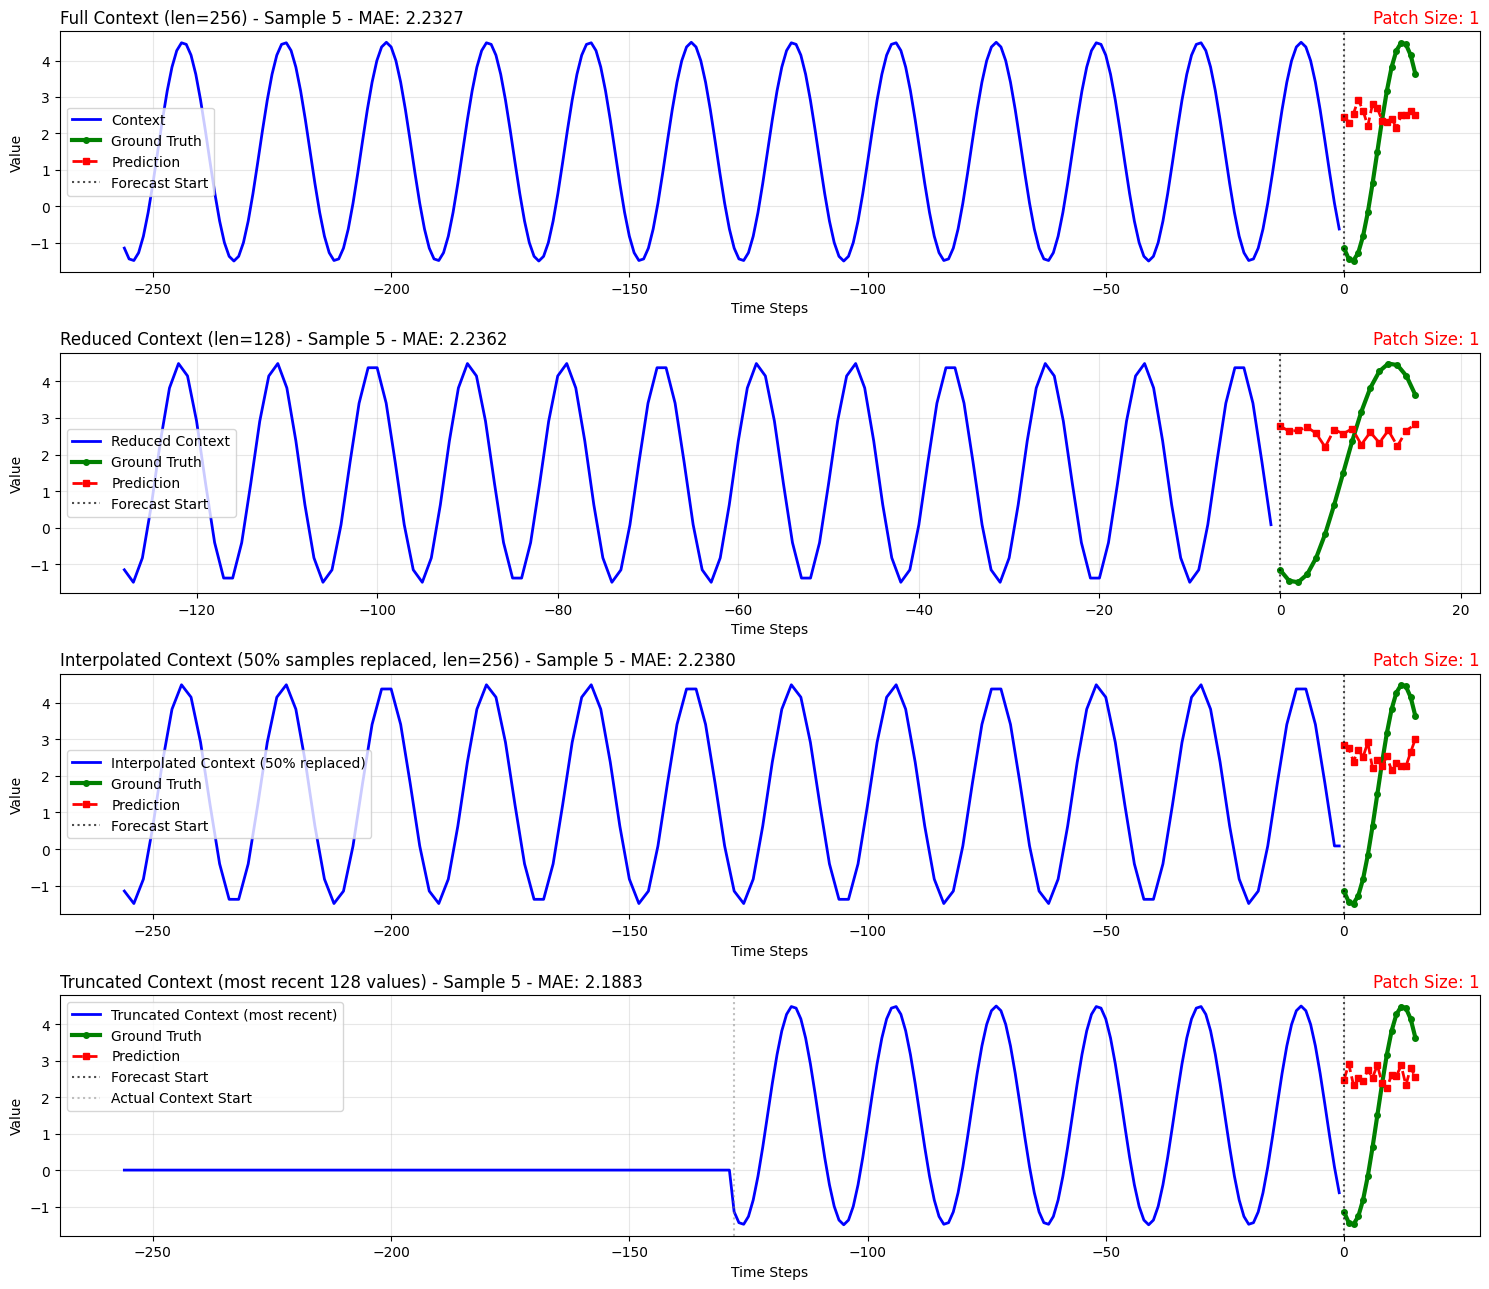

Saved plot: results_inf/synthetic_sinusoidal_moirai-large/sample_1_comparison.png


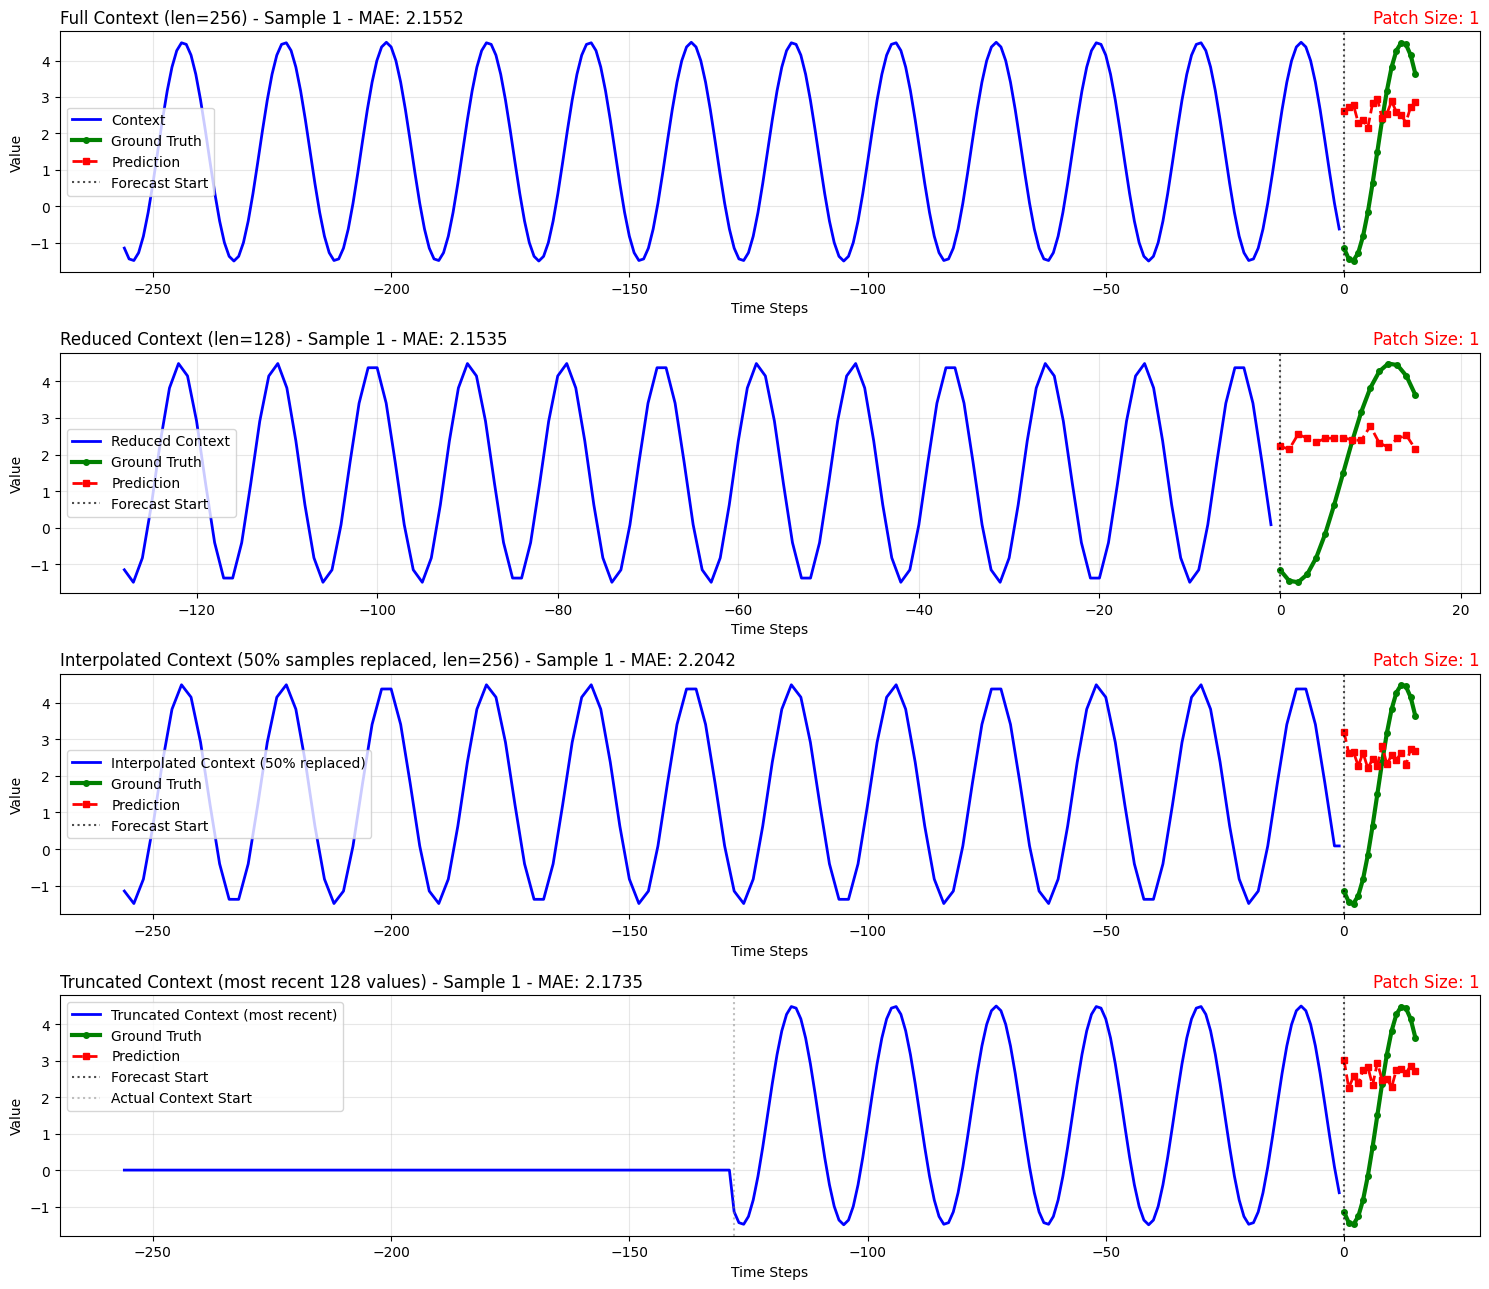

Saved plot: results_inf/synthetic_sinusoidal_moirai-large/sample_2_comparison.png


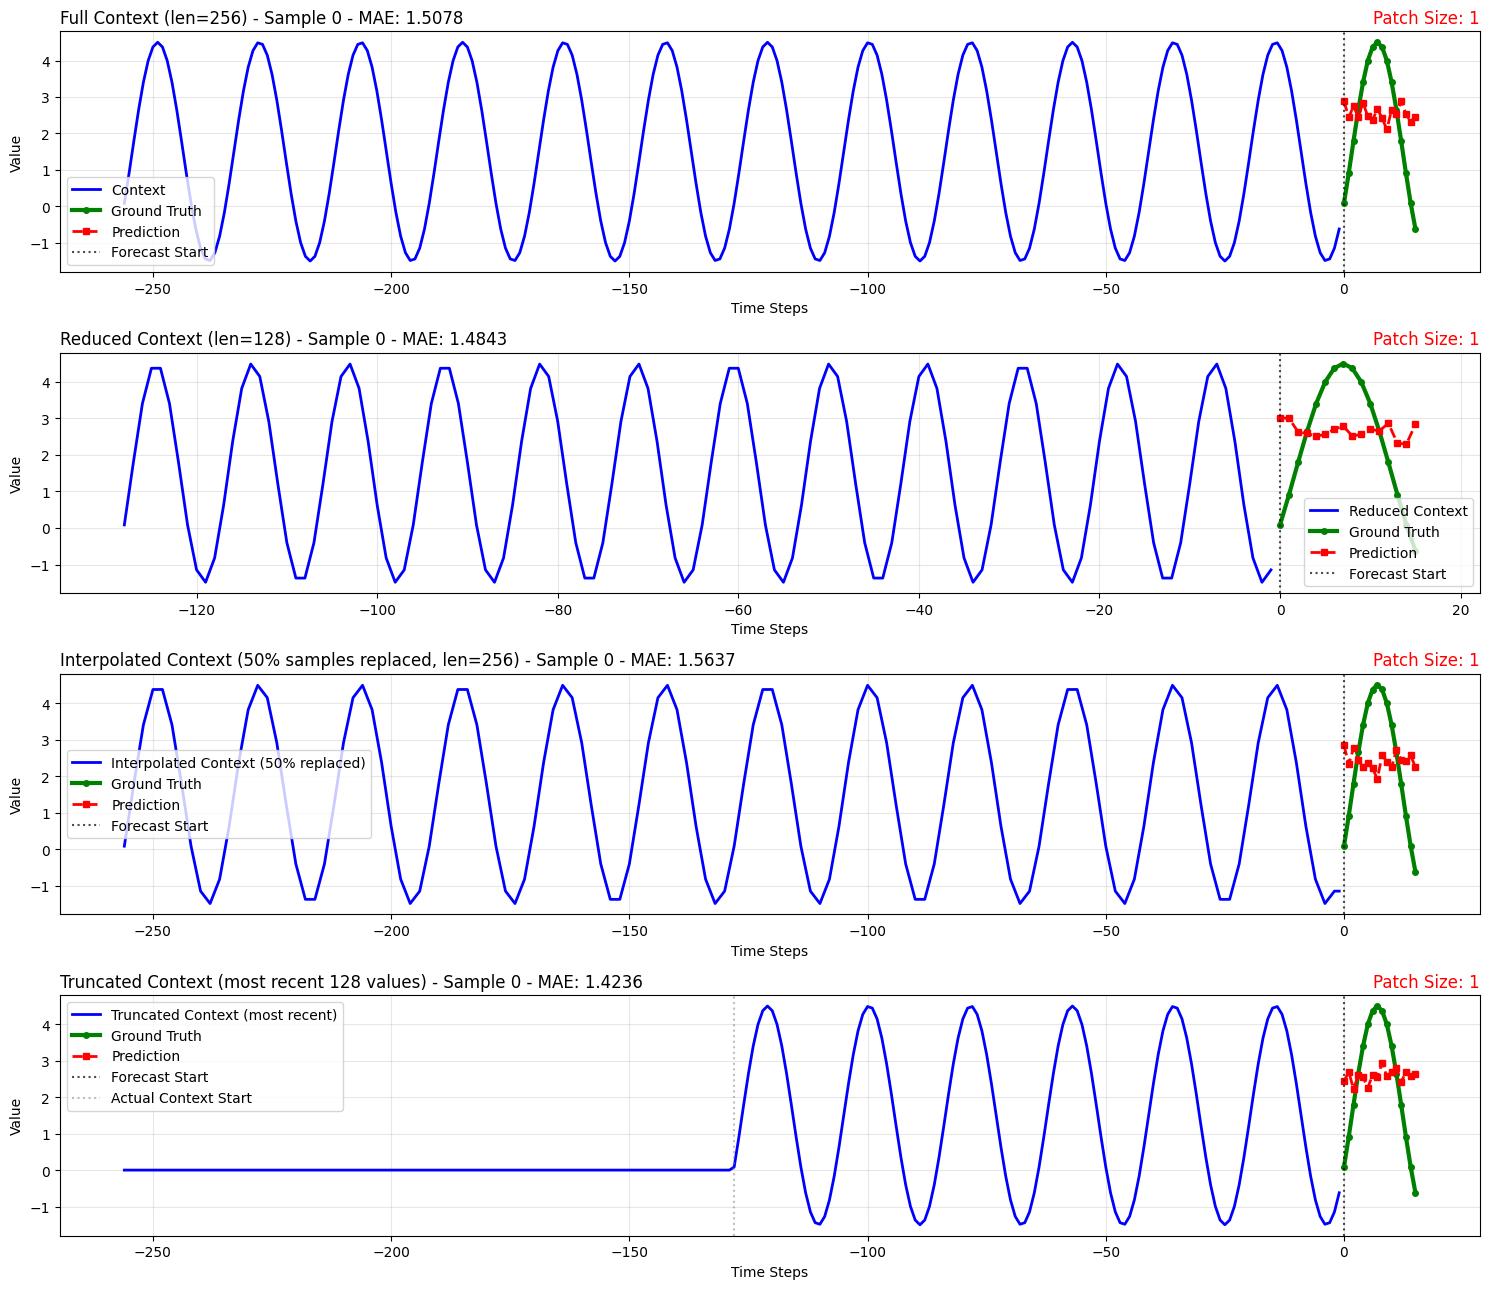

Saved plot: results_inf/synthetic_sinusoidal_moirai-large/sample_3_comparison.png


In [8]:
# plot the results. for 3 random samples, plot the context, ground truth and prediction for full, reduced, interpolated and truncated context; save the plots
num_samples = 3
sample_indices = np.random.choice(len(sample_results), num_samples, replace=False)
for plot_idx, idx in enumerate(sample_indices, 1):  # Start from 1 for filenames
    result = sample_results[idx]
    result_reduced = sample_results_reduced[idx]
    result_reduced_interpolated = sample_results_reduced_interpolated[idx]
    result_truncated = sample_results_truncated[idx]
    
    plt.figure(figsize=(15, 13))
    
    # Full context
    plt.subplot(4, 1, 1)
    # Create proper time indices
    context_len = len(result['context'])
    context_indices = np.arange(-context_len, 0)  # Context before 0
    forecast_indices = np.arange(0, PDT)  # Forecast starts at 0
    
    plt.plot(context_indices, result['context'], label='Context', color='blue', linewidth=2)
    plt.plot(forecast_indices, result['ground_truth'], label='Ground Truth', color='green', 
             linewidth=3, marker='o', markersize=4)
    plt.plot(forecast_indices, result['prediction'], label='Prediction', color='red', 
             linewidth=2, linestyle='--', marker='s', markersize=4)
    plt.axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    plt.title(f"Full Context (len={context_len}) - Sample {result['window_id']} - MAE: {result['mae']:.4f}", loc='left')
    plt.title(f"Patch Size: {PSZ}", loc='right', color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Reduced context
    plt.subplot(4, 1, 2)
    # Create proper time indices for reduced context
    context_len_reduced = len(result_reduced['context'])
    context_indices_reduced = np.arange(-context_len_reduced, 0)  # Context before 0
    forecast_indices = np.arange(0, PDT)  # Forecast starts at 0
    
    plt.plot(context_indices_reduced, result_reduced['context'], label='Reduced Context', color='blue', linewidth=2)
    plt.plot(forecast_indices, result_reduced['ground_truth'], label='Ground Truth', color='green', 
             linewidth=3, marker='o', markersize=4)
    plt.plot(forecast_indices, result_reduced['prediction'], label='Prediction', color='red', 
             linewidth=2, linestyle='--', marker='s', markersize=4)
    plt.axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    plt.title(f"Reduced Context (len={context_len_reduced}) - Sample {result_reduced['window_id']} - MAE: {result_reduced['mae']:.4f}", loc='left')
    plt.title(f"Patch Size: {PSZ}", loc='right', color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Reduced context with interpolation
    plt.subplot(4, 1, 3)
    # Create proper time indices for interpolated context
    context_len_interpolated = len(result_reduced_interpolated['context'])
    context_indices_interpolated = np.arange(-context_len_interpolated, 0)  # Context before 0
    forecast_indices = np.arange(0, PDT)  # Forecast starts at 0
    
    plt.plot(context_indices_interpolated, result_reduced_interpolated['context'], 
             label='Interpolated Context (50% replaced)', color='blue', linewidth=2)
    plt.plot(forecast_indices, result_reduced_interpolated['ground_truth'], label='Ground Truth', 
             color='green', linewidth=3, marker='o', markersize=4)
    plt.plot(forecast_indices, result_reduced_interpolated['prediction'], label='Prediction', 
             color='red', linewidth=2, linestyle='--', marker='s', markersize=4)
    plt.axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    plt.title(f"Interpolated Context (50% samples replaced, len={context_len_interpolated}) - Sample {result_reduced_interpolated['window_id']} - MAE: {result_reduced_interpolated['mae']:.4f}", loc='left')
    plt.title(f"Patch Size: {PSZ}", loc='right', color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Truncated context (most recent values, padded with zeros for consistent x-axis)
    plt.subplot(4, 1, 4)
    # Create proper time indices for truncated context with zero padding
    context_len_truncated = len(result_truncated['context'])
    
    # Pad with zeros to match full context length for consistent x-axis
    zeros_padding = np.zeros(context_len - context_len_truncated)
    padded_context = np.concatenate([zeros_padding, result_truncated['context']])
    
    # Create indices for the full context length
    context_indices_padded = np.arange(-context_len, 0)
    forecast_indices = np.arange(0, PDT)
    
    # Plot padded context (zeros will appear as flat line at bottom)
    plt.plot(context_indices_padded, padded_context, label='Truncated Context (most recent)', color='blue', linewidth=2)
    plt.plot(forecast_indices, result_truncated['ground_truth'], label='Ground Truth', 
             color='green', linewidth=3, marker='o', markersize=4)
    plt.plot(forecast_indices, result_truncated['prediction'], label='Prediction', 
             color='red', linewidth=2, linestyle='--', marker='s', markersize=4)
    plt.axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    plt.axvline(x=-context_len_truncated, color='gray', linestyle=':', alpha=0.5, label='Actual Context Start')
    plt.title(f"Truncated Context (most recent {context_len_truncated} values) - Sample {result_truncated['window_id']} - MAE: {result_truncated['mae']:.4f}", loc='left')
    plt.title(f"Patch Size: {PSZ}", loc='right', color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save plot
    plot_filename = os.path.join(results_dir, f"sample_{plot_idx}_comparison.png")
    plt.tight_layout()
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved plot: {plot_filename}")
